In [ ]:
from fastformer import FastformerForCausalLM, FastformerLMConfig
from transformers import TrainingArguments, Trainer, default_data_collator
from datasets import load_dataset

from itertools import chain


# redundant imports to reload library to allow for easy editing of fastformer code
import importlib
import fastformer
importlib.reload(fastformer)
FastformerForCausalLM = fastformer.FastformerForCausalLM
FastformerLMConfig = fastformer.FastformerLMConfig

In [ ]:
# t5 tokenzier, warning is nothing to worry about since we will group the texts
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-small")

C:\Users\micha\anaconda3\lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
raw_datasets = load_dataset("wikitext", "wikitext-2-raw-v1")
column_names = raw_datasets["train"].column_names
text_column_name = "text" if "text" in column_names else column_names[0]
block_size = 1024

def tokenize_function(examples):
    output = tokenizer(examples[text_column_name])
    return output

def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_datasets = raw_datasets.map(
            tokenize_function,
            batched=True,
            num_proc=1,
            remove_columns=column_names,
        )

lm_dataset = tokenized_datasets.map(
    group_texts,
    batched=True,
    num_proc=1,
    desc=f"Grouping texts in chunks of {block_size}",
)

lm_dataset.set_format('pt')

Reusing dataset wikitext (C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-f8c73e2d3f8f8bcb.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-6dae937f816b254a.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-afede17813c53203.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126\cache-eff406c3df5ba9d1.arrow
Loading cached processed dataset at C:\Users\micha\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126

In [ ]:
# hyperparameters
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "epoch",
    evaluation_strategy ="epoch",
    report_to = "none",
    learning_rate = 10e-4,
    num_train_epochs = 40,
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 4,
    save_strategy = "no",
)

config = FastformerLMConfig(
    hidden_size = 256, vocab_size = len(tokenizer), n_heads = 4,
    max_position_embeddings = block_size, groups = 1, kernel_size = 4,
    convolve = False, num_hidden_layers = 4, hidden_dropout_prob = .1,
    initializer_range = .02, label_smoothing = 0 # huggingface trainer seems to oddly apply label smoothing during validation so we won't use it
)

# 1. Additive attention adapted for causal language modeling

In [ ]:
fast_model = FastformerForCausalLM(config)

In [ ]:
pytorch_total_params = sum(p.numel() for p in fast_model.parameters() if p.requires_grad)
f'{(pytorch_total_params / 1e6):2.1f}M'

'11.7M'

In [ ]:
fast_trainer = Trainer(
    model=fast_model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["validation"]
)

fast_trainer.train()

# 2. Add convolution

In [ ]:
config.convolve = True

# decrease by a layer to make room for the convolutional layer
config.num_hidden_layers = 3

conv_model = FastformerForCausalLM(config)

In [ ]:
pytorch_total_params = sum(p.numel() for p in conv_model.parameters() if p.requires_grad)
f'{(pytorch_total_params / 1e6):2.1f}M'

'11.7M'

In [ ]:
conv_trainer = Trainer(
    model=conv_model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["validation"]
)


conv_trainer.train()

# 3. GPT2 (comparision)

In [ ]:
from transformers import GPT2Config, GPT2LMHeadModel
config = GPT2Config(n_embd = 256, vocab_size=len(tokenizer),
                    n_positions = block_size, n_layer = 4, n_head = 4,
                    resid_pdrop = .1, embd_pdrop = .1, attn_pdrop = .1,
                    use_cache = False, summary_use_proj = False, summary_proj_to_labels = False
                   )
gpt_model = GPT2LMHeadModel(config)

In [ ]:
pytorch_total_params = sum(p.numel() for p in gpt_model.parameters() if p.requires_grad)
f'{(pytorch_total_params / 1e6):2.1f}M'

'11.6M'

In [ ]:
# label smoothing only for gpt model (fastformer implements it manually)
# training_args.label_smoothing_factor = .1
training_args.label_smoothing_factor = 0

gpt_trainer = Trainer(
    model=gpt_model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=lm_dataset["train"],
    eval_dataset=lm_dataset["validation"]
)

gpt_trainer.train()

# Results

In [ ]:
def format_num_param(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return f'{(pytorch_total_params / 1e6):2.1f}M'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

loss1 = pd.DataFrame(fast_trainer.state.log_history[1::2]).set_index("epoch")["eval_loss"]
loss2 = pd.DataFrame(conv_trainer.state.log_history[1::2]).set_index("epoch")["eval_loss"]
loss3 = pd.DataFrame(gpt_trainer.state.log_history[1::2]).set_index("epoch")["eval_loss"]
results = pd.DataFrame({f"Additive Attention ({format_num_param(fast_model)} parameters)": loss1,
                        f"Convolutional Additive Attention ({format_num_param(conv_model)} parameters)": loss2,
                        f"GPT2 (4.11M parameters) ({format_num_param(gpt_model)} parameters)": loss3
                       }).iloc[:-1] # last row is a repeat
results.to_csv("results.csv")
results

,Additive Attention (11.6M parameters),Convolutional Additive Attention (11.6M parameters),GPT2 (4.11M parameters) (11.6M parameters)
epoch,,,
1.0,5.705959,5.428772,5.221456
2.0,5.453678,5.093087,5.005669
3.0,5.312072,4.902125,4.881087
4.0,5.268246,4.816107,4.819417
5.0,5.152525,4.748998,4.761693
6.0,5.101096,4.669534,4.727694
7.0,5.083707,4.654128,4.703269
8.0,5.050272,4.617165,4.683393
9.0,5.033623,4.599461,4.683642


In [ ]:
ppl_results = np.exp(results)
ppl_results

,Additive Attention (11.6M parameters),Convolutional Additive Attention (11.6M parameters),GPT2 (4.11M parameters) (11.6M parameters)
epoch,,,
1.0,300.653765,227.869244,185.203565
2.0,233.615857,162.891966,149.256849
3.0,202.769892,134.575497,131.773864
4.0,194.075197,123.483408,123.892899
5.0,172.867421,115.468491,116.943800
6.0,164.201721,106.648004,113.034554
7.0,161.371128,105.017613,110.307126
8.0,156.064906,101.206713,108.136358
9.0,153.488127,99.430716,108.163277


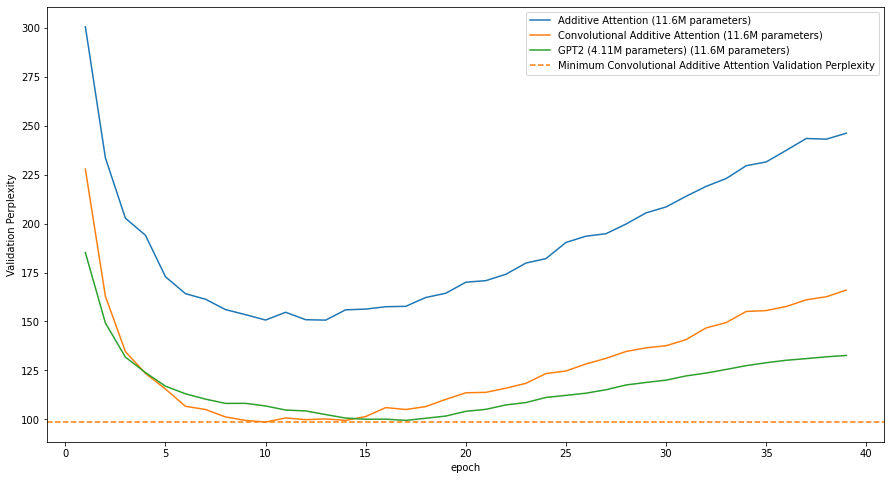

In [ ]:
ppl_results.plot()

plt.ylabel("Validation Perplexity")
plt.axhline(y=ppl_results[f"Convolutional Additive Attention ({format_num_param(conv_model)} parameters)"].min(),
            linestyle='--', label = "Minimum Convolutional Additive Attention Validation Perplexity", color = 'C1')
plt.legend()
plt.savefig('results.png')
plt.show()

# Appendix

In [ ]:
# test_number = 94

# input_ids = lm_dataset["train"][test_number]["input_ids"].reshape(1, -1).cpu()
# attention_mask = lm_dataset["train"][test_number]["attention_mask"].reshape(1, -1).cpu()
# labels = lm_dataset["train"][test_number]["labels"].reshape(1, -1).cpu()

In [ ]:
# test_model = FastformerForCausalLM(config)
# test_model.load_state_dict(torch.load("./results\checkpoint-33400\pytorch_model.bin"))

# test_model = test_model.cpu().eval()
# out = test_model(input_ids=input_ids, labels = labels, attention_mask = attention_mask)
# logits = out.logits
# loss = out.loss
# loss

In [ ]:
# generated_tokens = test_model.generate(input_ids[:,:50], do_sample=True, max_length=256, temperature = .01)
# tokenizer.batch_decode(generated_tokens)